In [ ]:
#importing the libraries

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [106]:
#loading the dataset and displaying the first five rows

df = pd.read_csv("Fraud Detection.csv")
df.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,300,TRANSFER,890577.21,C1610053124,218.00,0.00,C2134570494,0.00,890577.21,0,0
1,399,CASH_IN,97734.24,C1159686943,2096258.84,2193993.08,C1110663773,320136.00,222401.76,0,0
2,718,PAYMENT,5907.41,C1079460540,315.00,0.00,M143445429,0.00,0.00,0,0
3,186,CASH_OUT,187696.30,C1351948367,11057.00,0.00,C1425776462,1798095.21,1985791.51,0,0
4,331,CASH_OUT,82646.52,C2112196651,0.00,0.00,C1864764190,1047805.87,1130452.39,0,0


Exploratory Data Analysis

In [107]:
#to check the shape of the dataset

df.shape

(1272524, 11)

In [108]:
#to check the null values in dataset

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
isFraud           0
dtype: int64

In [109]:
# to get the stats of the dataset

df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
count,1.272524e+06,1.272524e+06,1.272524e+06,1.272524e+06,1.272524e+06,1.272524e+06,1272524.0,1.272524e+06
mean,2.435357e+02,1.796712e+05,8.344360e+05,8.557838e+05,1.101975e+06,1.225808e+06,0.0,1.291135e-03
std,1.423805e+02,6.094278e+05,2.890807e+06,2.926696e+06,3.381787e+06,3.662988e+06,0.0,3.590917e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
25%,1.560000e+02,1.338444e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
50%,2.390000e+02,7.499696e+04,1.419392e+04,0.000000e+00,1.323189e+05,2.133365e+05,0.0,0.000000e+00
75%,3.350000e+02,2.088578e+05,1.072380e+05,1.446266e+05,9.424838e+05,1.109463e+06,0.0,0.000000e+00
max,7.430000e+02,7.382349e+07,4.368662e+07,4.367380e+07,3.279630e+08,3.281945e+08,0.0,1.000000e+00


In [110]:
#importing data visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns

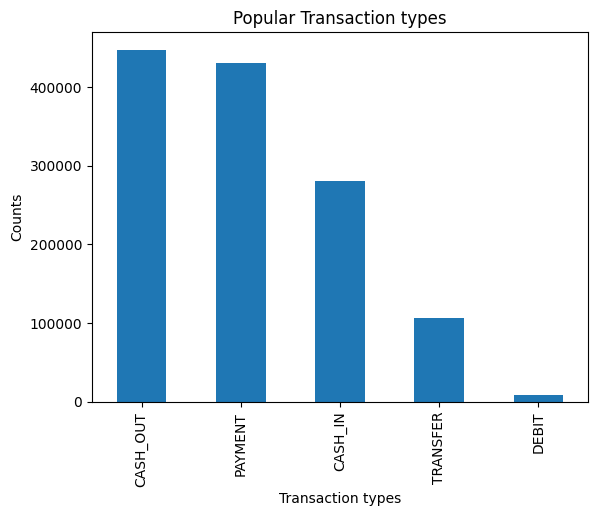

In [111]:
# to check the most popular transaction types

df["type"].value_counts().plot(kind = "bar", title = "Popular Transaction types",)
plt.xlabel("Transaction types")
plt.ylabel("Counts")
plt.show()

In [112]:
# to check where fraud occurs more

df.groupby("type")["isFraud"].mean().sort_values(ascending=False)

type
TRANSFER    0.007932
CASH_OUT    0.001784
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [113]:
# to find the percentage of Fraud Transactions
fraud_transactions = df["isFraud"].value_counts()[1]/df.shape[0]
percentage_of_fraud = round(fraud_transactions * 100,2)
percentage_of_fraud

np.float64(0.13)

In [114]:
#drop unnecessary columns
df = df.drop(["step","nameOrig","nameDest","isFlaggedFraud"],axis=1)

In [115]:
#cross verify if the columnms are dropped

df.head(5)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,TRANSFER,890577.21,218.00,0.00,0.00,890577.21,0
1,CASH_IN,97734.24,2096258.84,2193993.08,320136.00,222401.76,0
2,PAYMENT,5907.41,315.00,0.00,0.00,0.00,0
3,CASH_OUT,187696.30,11057.00,0.00,1798095.21,1985791.51,0
4,CASH_OUT,82646.52,0.00,0.00,1047805.87,1130452.39,0


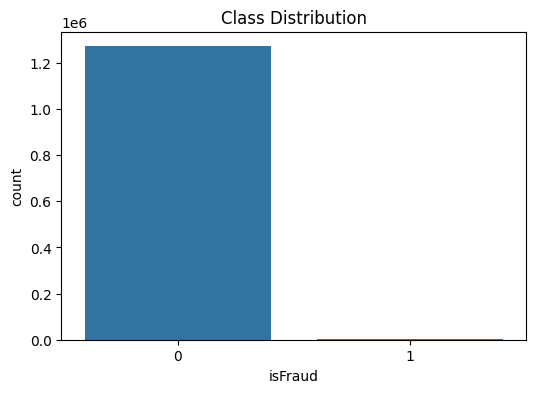

In [116]:
# to check class distrribution 

plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=df)
plt.title("Class Distribution")
plt.show()


### Since the class distribution is very imbalanced, we have to make it balanced before building the model

In [117]:
from sklearn.preprocessing import LabelEncoder

In [118]:
label_encoder = LabelEncoder()
df["Type_Encoded"] = label_encoder.fit_transform(df["type"])

In [119]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Type_Encoded
0,TRANSFER,890577.21,218.00,0.00,0.00,890577.21,0,4
1,CASH_IN,97734.24,2096258.84,2193993.08,320136.00,222401.76,0,0
2,PAYMENT,5907.41,315.00,0.00,0.00,0.00,0,3
3,CASH_OUT,187696.30,11057.00,0.00,1798095.21,1985791.51,0,1
4,CASH_OUT,82646.52,0.00,0.00,1047805.87,1130452.39,0,1


In [88]:
X = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'Type_Encoded']]
y = df["isFraud"]

In [89]:
#resampling the data

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

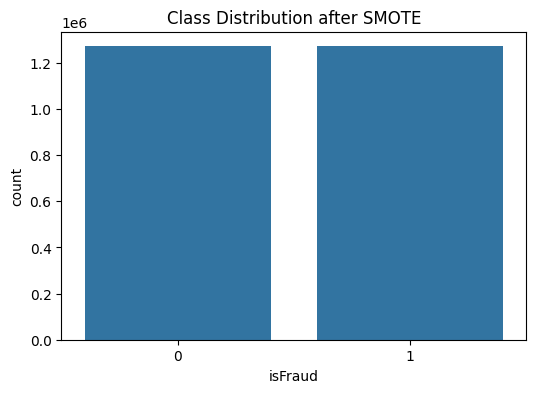

In [90]:
# to check the class distribution after SMOTE

plt.figure(figsize=(6,4))
sns.countplot(x=y_resampled)
plt.title("Class Distribution after SMOTE")
plt.show()

In [91]:
from sklearn.model_selection import train_test_split


In [120]:
X_train, X_test, y_train,y_test = train_test_split(X_resampled,y_resampled,test_size = 0.2, random_state = 42)

In [121]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [122]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=3,   # allow some depth for splits
    n_estimators=200,
)
lgb_model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [124]:
y_pred = lgb_model.predict(X_test)

In [125]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    254438
           1       0.98      1.00      0.99    253915

    accuracy                           0.99    508353
   macro avg       0.99      0.99      0.99    508353
weighted avg       0.99      0.99      0.99    508353



In [128]:
lgb_model.score(X_test, y_test)

0.9905341367120879

In [129]:
import joblib

In [130]:
joblib.dump(lgb_model,"lgb_model.pkl")

['lgb_model.pkl']